# Introduction to Virtual Sensing
*Created: M.M., 23.5.2024*

In [1]:
import numpy as np
from scipy.linalg import expm
from numpy.linalg import matrix_power
from scipy import signal
import matplotlib.pyplot as plt
import cvxpy as cp

ModuleNotFoundError: No module named 'matplotlib'

## 1.1. Contineous linear time-invarient (LTI) systems
Consider a contineous-time LTI system

\begin{align}
\dot{x}(t) &= Ax(t) + Bu(t)\\
y(t) &= Cx(t).
\end{align}

To solve the differential equaiton first recall that (cf. [wiki.](https://en.wikipedia.org/wiki/Discretization#Derivation))

\begin{equation}
\frac{\mathrm{d}}{\mathrm{d}t}\left( \mathrm{e}^{-At}x(t) \right) = \mathrm{e}^{-At}\left(\dot{x}(t) - Ax(t)\right)
\end{equation}

(by the product rule). Pre-multiplying the state-equation with $\mathrm{e}^{-At}$ and rearranging the terms gives

\begin{equation}
    \mathrm{e}^{-At}\left( \dot{x}(t) - Ax(t) \right) = \mathrm{e}^{-At}Bu(t)
\end{equation}

or  equivalently

\begin{equation}
    \frac{\mathrm{d}}{\mathrm{d}t}\left( \mathrm{e}^{-At}x(t) \right) = \mathrm{e}^{-At}Bu(t).
\end{equation}

Integrating the above expression from $0$ to $t$ gives

\begin{equation}
    \mathrm{e}^{-At}x(t) -  x(0) = \int_{0}^{t}\mathrm{e}^{-A(t - \tau)}Bu(\tau) \mathrm{d}\tau
\end{equation}

and multiply by $\mathrm{e}^{At}$ yields

\begin{equation}
    x(t) =  \mathrm{e}^{At}x(0) + \int_{0}^{t}\mathrm{e}^{A(t-\tau)}Bu(\tau) \mathrm{d}\tau.
\end{equation}

The impulse response is obtained by passing the input signal $u(t)=\delta(t)$, where $\delta$ is the Dirac's delta function (see e.g. [wiki.](https://en.wikipedia.org/wiki/Dirac_delta_function)). Setting $x(0) = 0$ gives the impulse response

\begin{equation}
y_\delta(t) = C\mathrm{e}^{At}B.
\end{equation}


In [2]:
def impulsec(A,B,C,time):
    """
    IMPULSEC returns the impulse response h of a contineous-time state-space system (A,B,C).
    """
    N = time.shape[0]
    m,nb = B.shape
    h = np.zeros((N,nb))
    for i,t in enumerate(time):
       h[i,:] = C@expm(A*t)@B
    return h

## 1.2. Discrete-time LTI systems
Given a continous-time state-space model $(A_\mathrm{c},B_\mathrm{c},C)$. If measurements $y$ are obtained with a constant sampling time $T_\mathrm{s}$ at time instances $t \in \{kT_\mathrm{s}$: $k=0,1,2,...\}$. assuming that $u$ is constant inbetween samples, a discrete-time state space representation is of the form (cf. [wiki.](https://en.wikipedia.org/wiki/Discretization#Derivation))

$$
\begin{align}
    x(k+1) &= Ax(k) + Bu(k),\\
    y(k) &= Cx(k),
\end{align}
$$

where, $u$ is an input vector, and

$$
\begin{align}
A &= \mathrm{e}^{A_\mathrm{c}T_\mathrm{s}}\\
B &= A_\mathrm{c}^{-1}( A - I )B.
\end{align}
$$

Note that if $A_\mathrm{c}$ is singular, $B$ cannot be computed in this way. However, there are other ways to compute the $B$ matrix. Below is an implementation of MATLABs `c2d()` function.


In [3]:
def c2d(A,B,Ts):
    """
    C2D computes a discrete-time model of a system (A_c,B_c) with sample time T_s.
    The function returns matrices A,B of the discrete-time system.
    """
    m,n = A.shape
    m,nb = B.shape

    s = np.concatenate([A,B], axis=1)
    s = np.concatenate( [s, np.zeros( (nb,n+nb) )],axis=0 )
    S = expm(s*Ts)
    Ad = S[0:n,0:n]
    Bd = S[0:n,n:n+nb+1]
    return Ad, Bd

### 1.2.1. Impulse response
The **impulse response** is is obtained by passing an input signal $u(0)=1$ and $u(k)=0$ for $k\neq 0$ through the system. For initial state $x(0)=0$, yhe impulse response is

\begin{align}
    y_\delta(0) &= 0\\
    y_\delta(1) &= Cx(1) = C(Ax(0) + B) = CB\\
    y_\delta(2) &= Cx(2) = C( Ax(1) ) = C( A( Ax(0) + B ) ) = CAB\\
    &\vdots \\
    y_\delta(n) &= CA^{n-1}B, n>0. 
\end{align}


In [4]:
def impulsed(A,B,C,T_s,N):
    """
    IMPULSED returns the impulse response h of a discrete-time state-space system (A,B,C).
    """
    r,n = C.shape
    n,nb = B.shape
    h = np.zeros((N,nb))
    for i in range(N):
        if i==0:
            h[i,:] = np.zeros((r,nb))
        else:
            h[i,:] = C@matrix_power(A,i)@B/T_s    #why divide by Ts here?
    return h

### 1.2.2. The data equation
Repeated substitution of $x(k)$ into $y(k)=Cx(k)$ gives

$$
\begin{aligned}
    y(0) &= Cx(0),\\
    y(1) &= CAx(0) + Bu(0),\\
    \vdots &\\
    y(n) &= CA^{n}x(0) + \sum_{k=0}^{n-1} CA^{k}u(n-k-1),\\
    \vdots &
\end{aligned}
$$

or in matrix form

$$
\underbrace{
\begin{bmatrix}
y(0)\\
y(1)\\
y(2)\\
\vdots\\
y(N-1)
\end{bmatrix}
}_{y}
=
\underbrace{
\begin{bmatrix}
C\\
CA\\
CA^2\\
\vdots\\
CA^{N-1}
\end{bmatrix}
}_{\mathcal{O}}
x(0)
+
\underbrace{
\begin{bmatrix}
0 &0 &\cdots &0\\
CB &0 &\cdots &0\\
CAB &CB &\cdots &0\\
\vdots &\vdots &\ddots &\vdots\\
CA^{N-2}B &CA^{N-3}B &\cdots &0
\end{bmatrix}
}_{\Gamma}
\underbrace{
\begin{bmatrix}
u(0)\\u(1)\\u(2)\\ \vdots\\ u(N-1)
\end{bmatrix}
}_{u}.
$$

The section on *subspace system identification* in the book [Filtering and System Identification](https://books.google.fi/books?hl=sv&lr=&id=6Ne76uYOlVwC&oi=fnd&pg=PR11&dq=verhaegen+least+squares+approach&ots=H7GzIs_Rab&sig=PfKVrPuYiSlWfjI3_tymLiI1-U8&redir_esc=y#v=onepage&q=verhaegen%20least%20squares%20approach&f=false) by Verhaegen, Michel, and Vincent Verdult explains this well (*read*: check that I havent done any mistakes here).

* **Note**: This equation is commonly occuring in the control-theory and system identification litterature and is often referred to as the *data equation*. Here I have used the standard notation $\mathcal{O}$ for the extended observability matrix (which is used for determining stability of a system), and $\Gamma$ for the impulse response matrix. The impulse response of the system is $h(k) = CA^{k-1}B$. In [(Ikonen et al.,2015)](https://www.sciencedirect.com/science/article/pii/S0165232X14002274), the non-standard notation  $g(k)=h(k)$, $R=y$, $G = \Gamma$, and $M = u$ was used instead.


In [220]:
def obsv(A, C, n):
    '''
    Create the extended observability matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    O : numpy.ndarray, shape(n, number of state variables)
        The extended observability matrix
    '''
    O = C
    for k in range(1, n):
        O = np.vstack((O, C @ np.linalg.matrix_power(A, k)))

    return O

# I got some errors with your function, so I modified the solution I found from stackexchange:
# https://scicomp.stackexchange.com/questions/33239/is-there-an-efficient-way-to-form-this-block-matrix-with-numpy-or-scipy

def Gamma(A,B,C,N):
    '''
    Create the impulse response matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    B : numpy.ndarray
        The input matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    gamma : numpy.ndarray, shape(n*number of state variables, n*number of state variables)
        The impulse response matrix
    '''
    mat_list = []
    n = (C@B).shape[0]
    m = (C@B).shape[1]
    for i in range(N): # generate row
        tmp = []
        for j in range(N): # loop through A^j*B
            if j <= i:
                tmp.append(C@np.linalg.matrix_power(A,i-j)@B)
        if i < N-1:
            tmp.append(np.zeros((n, m*(N-1-i))))
        mat_list.append(tmp)
        G = np.block(mat_list)
        #add zero row and column
        n,m = (C@B).shape
        ng,mg = G.shape
        G = np.append(np.zeros((n,mg)),G,axis=0)
        G = np.append(G,np.zeros((n+ng,m)),axis=1)
    return G

### 1.2.3. Example: Mass-spring-damper system
Let's define a contineous-time 2-mass spring-damper system

In [6]:
# Consider the mass-spring-damper system of the form
# dx/dt = Ax + B_1u-1 + B_2u_2
# where u_1 is a known input signal, and u_2 is unknown.

# spring, damper, mass parameters
I_1 = .1    #inertia [kgm^2]
I_2 = .5
k = 1    #stiffness [Nm/rad]
c = .2  #damping [Nm/(rad/s)]

#contineous-time state space
Ac = np.matrix([[-c/I_1, c/I_1, -k/I_1],[c/I_2, -c/I_2, k/I_2],[1, -1, 0]])
Bc = np.matrix([[1/I_1, 0],[0, 1/I_2],[0, 0]])

The discrete-time system is obtaind by assuming zero-order hold (zoh).

In [11]:
#sampling time
Ts = 0.1

#discrete-time system
A, B = c2d(Ac,Bc,Ts) 

The **impulse response** of the discrete and contineous-time systems are compared

Text(0.5, 1.0, 'Impulse response u_2 to y')

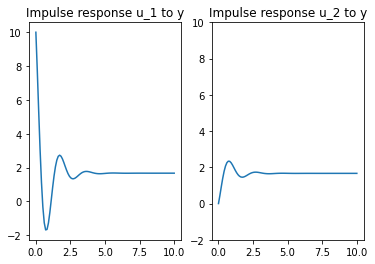

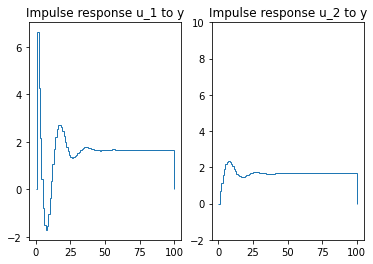

In [14]:
N = 100
t_max = 10
Nd = int(t_max/T_s)
time = np.linspace(0, t_max, num=N)
C = np.array([[1, 0, 0]])

#impulse response
h_c = impulsec(Ac,Bc,C,time)
h_d = impulsed(A,B,C,T_s,Nd)

#plot impulse response
fig, axs = plt.subplots(1, 2)
plt.ylim([-2, 10])
axs[0].plot(time,h_c[:,0])
axs[1].plot(time,h_c[:,1])

axs[0].set_title("Impulse response u_1 to y")
axs[1].set_title("Impulse response u_2 to y")

#plot impulse response
fig, axs = plt.subplots(1, 2)
plt.ylim([-2, 10])
axs[0].stairs(h_d[:,0])
axs[1].stairs(h_d[:,1])

axs[0].set_title("Impulse response u_1 to y")
axs[1].set_title("Impulse response u_2 to y")

Next, let's **simulate** the system to generate some data.

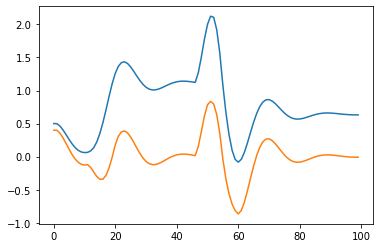

In [354]:

def sim(A,B,C,u,x0):
    n = A.shape[0]
    r = C.shape[0]
    x = np.concatenate([x0,np.zeros((n,N-1))],axis=1)
    #x = np.zeros((n,N))
    y = np.zeros((r,N))
    for k in range(N):
        if k==0:
            y[:,k] = C@x[:,k]
        else:
            x[:,k] = A@x[:,k-1] + B@u[:,k-1]
            y[:,k] = C@x[:,k]
    return x, y

#simulation parameters
N = 100
d = np.array([0, 0.34, 0.64, 0.87, 0.98, 0.98, 0.87, 0.64, 0.34, 0]).reshape((1,10))
#u1 = np.zeros((1,N))
u0 = np.concatenate( [np.zeros((1,45)), 0.5*d, np.zeros((1,45))], axis=1 )
u1 = np.concatenate( [np.zeros((1,10)), d, np.zeros((1,30)), -d, np.zeros((1,40))], axis=1 )
u = np.concatenate([u0,u1],axis=0)

#measurement (angular velocity + twist)
C = np.array([[1, 0, 0],[1, -1, 0]])

#simulate
x0 = np.array([[0.5,0.1,-0.1]]).T
x, y = sim(A,B,C,u,x0)

#plot
plt.plot(y[0,:])
plt.plot(y[1,:])


Compute $\mathcal{O}$ and $\Gamma$ in the **data equation**

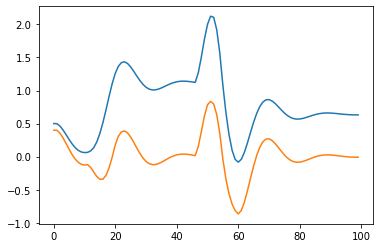

In [355]:
O = obsv(A, C, N)
G = Gamma(A, B, C, N-1)

# verify that we get the same result as previously using Gamman and Oe
U = np.reshape( u.T, (-1,1) )
Y = np.reshape( y.T, (-1,1) )
yhat = O@x0 + G@U

#plot
plt.plot(yhat[0::2])
plt.plot(yhat[1::2])


## 2.1. Input Estimation by Convex Optimization
If $u$ is  unknown input (disturbance), the goal of the estimation is to reconstructed from $N$ measurements $y(0), y(1), .., y(N-1)$

In the following paper, the input-estimation problem was posed as an regularized inverse problem.

* Ikonen T., Peltokorpi, O. & Karhunen J. (2015),[Inverse ice-induced moment determination on the propeller of an ice-going vessel](https://www.sciencedirect.com/science/article/pii/S0165232X14002274). Cold Regions Science and Technology, 112, 1-13.

A more straight-forward derivation of the results presented in the paper is obtained by starting from a state-space representation of the system (see e.g. [Manngård et al., (2018)](https://www.sciencedirect.com/science/article/pii/S0888327022001480), [Manngård et al., (2022)](https://www.sciencedirect.com/science/article/pii/S2405896319321822) on how to represent drivetrains in a state-apace form).

###  2.1.1. Tikhonov regularization
Since $y,\mathcal{O},$ and $\Gamma$ are known, we can, for example, estimate $u$ by solving a Tikhonov-regularized quadratic optimization problem:

$$
\underset{u, x(0)}{\mathrm{min}} || y - \mathcal{O}x(0) - \Gamma u ||^2_2 + \lambda|| Lu ||^2_2,
$$

where $\lambda$ is a regularization parameter and $L$ is a regularization matrix (to be determined by the used). The purpose of the matrix $L$ is to enforce additional constraints of the solution, such as smoothness. For $x(0)=0$ the Tikhonov regularized optimization problem has the solution is

$$
\hat{u} = \left(  \Gamma^\top \Gamma + \lambda L^\top L  \right)^{-1} \Gamma^\top \big( y - \mathcal{O}x(0) \big).
$$

* **Note** that we have treated the initial state $x(0)$ as unknown and to be estimated (as is the case in most applications). However, if we set $x(0)=0$, the same solution as in Eq. 33 in the paper by [Ikonen et al.,(2015)](https://www.sciencedirect.com/science/article/pii/S0165232X14002274) is obtained.

The difference between this approach, and Kalman filtering is that the Kalman filter produces  optimal estimates of the state $x(n)$ and inputs (disturbances) $u(n)$ based on the observations $y(0),...,y(n)$ observed up until time-instance $n$, whereas the optimization method used all available measurements $\{y(0),y(1),...,y(n),... y(N)\}$ as a batch. Thus, the optimization approach is expected to perform better than the Kalman filter. However, the effect that the regularization has on the results may be hard to analyze, and solving the optimization problem in real-time myght be a challenge. Especially if the sampling rate is high.


In [434]:
# Tikhonov regularization
def tikhonov_optimization_problem(y, O, gamma, L, lam=1):
    '''
    Convex optimization methods using the cvxpy library.
    '''
    u = cp.Variable((gamma.shape[1], 1), complex=False)
    x0 = cp.Variable((O.shape[1], 1), complex=False)
    objective = cp.Minimize(cp.sum_squares(y - O @ x0 - gamma @ u) + lam * cp.sum_squares(L @ u))
    prob = cp.Problem(objective)
    prob.solve()

    return u.value, x0.value, prob.value

# the Tikhnoov regularized regresison problem has an explixit solution for known x0
def tikhonov_explicit_solution(y, O, gamma, L, x0, lam=1):
    u = np.linalg.inv( gamma.T @ gamma + lam * L.T @ L ) @ gamma.T @ ( y - O @ x0 )
    return u


Solve the Tikhonov-regularized input-reconstruction problem.

Estimate of initial state:  [[ 0.52083806  0.10763163 -0.10097614]]


Text(0.5, 1.0, 'Input y')

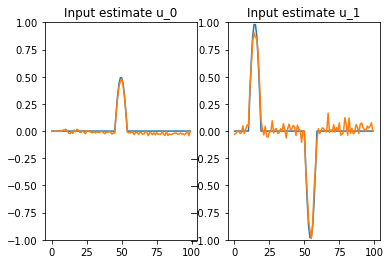

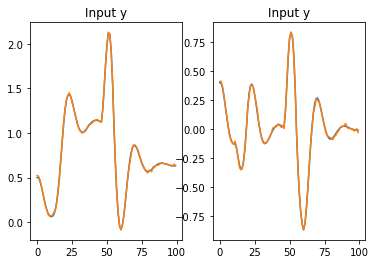

In [554]:
#regularization matrix
L = np.eye(B.shape[1]*N)
# add measurement noise
e = np.random.normal(0, .01, Y.shape[0]).reshape( (-1,1) )
Y_noise = Y + e

#solve optimization problem
lam = 1000
Uhat, x0hat, fval = tikhonov_optimization_problem(Y_noise, O, G, L, lam=0.01)

print('Estimate of initial state: ', x0hat.T)

#plot estimates
fig, axs = plt.subplots(1, 2)
axs[0].plot(U[0::2])
axs[0].plot(Uhat[0::2])
axs[0].set_ylim((-1, 1))
axs[0].set_title("Input estimate u_0")

axs[1].plot(U[1::2])
axs[1].plot(Uhat[1::2])
axs[1].set_ylim((-1, 1))
axs[1].set_title("Input estimate u_1")

fig, axs = plt.subplots(1, 2)
axs[0].plot(Y[0::2])
axs[0].plot(Y_noise[0::2])
axs[0].set_title("Input y")
axs[1].plot(Y[1::2])
axs[1].plot(Y_noise[1::2])
axs[1].set_title("Input y")  #why this gives a warning?


**Remark** In this exemple, the Tikhonov regularized problem does not seem to handle measurement noise that well. The reson for this is mainly that since both inputs are known, we have enough degrees of freedom to overfit to noise. 

If we want to enforce the input estimates to be smooth, we can determine the weighting matrix $L$ in a way that the second-difference of $u$ is small. Resulting in a smooth trend. This method is commonly known as a [Hodrick-Prescott filter](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=252beab6793faa07d7270cd4ddd9861c20597f4e) (H-P filter).

### 2.1.2. Hodrick-Prescott trend filtering
In H-P filtering, the regularization term minimizes the $\ell_2$ norm of the second difference $u(k-1) - 2u(k) + u(k+1)$

$$
\underset{u, x(0)}{\mathrm{min}} || y - \mathcal{O}x(0) - \Gamma u ||^2_2 + \lambda \sum_{t=1}^{N-1}\big( u(k-1) - 2u(k) + u(k+1) \big)^2  .
$$

If the second difference of a signal is small, the signal is smooth. For scalar inputs, the H-P regularization is exactly of the same form as the Tikhonov regularized optimization problem if we define the $L$ matrix as

\begin{equation}
    L =
    \begin{bmatrix}
    1 &-2 &1      &       &       & \\
      &1  &-2     &1      &       & \\
      &   &\ddots &\ddots &\ddots & \\
      &   &       &1      &-2     &1
    \end{bmatrix}.
\end{equation}

For multiple input signals, the elements in the $L$ needs to be rearranged accordingly. For **example**, if the system has two input signals

\begin{equation}
    u(k) = 
    \begin{bmatrix}
    u_0(k)\\
    u_1(k)
    \end{bmatrix},
    U = 
    \begin{bmatrix}
    u_0(0)\\u_1(0)\\
    \hline
    u_0(1)\\u_1(1)\\
    \hline
    u_0(2)\\u_1(2)\\
    \end{bmatrix},
\end{equation}
the second difference $D^2U$ can be written in matrix form as

\begin{equation}
    \begin{bmatrix}
    u(1) - 2u(1) + u(1)\\
    \hline
    u(2) - 2u(2) + u(2)\\
    \end{bmatrix}
    =
    \begin{bmatrix}
    u_0(1) - 2u_0(1) + u_0(1)\\
    u_1(1) - 2u_1(1) + u_1(1)\\
    \hline
    u_0(2) - 2u_0(2) + u_0(2)\\
    u_1(2) - 2u_1(2) + u_1(2)\\
 \end{bmatrix}
 =
 \begin{bmatrix}
    1 &0  &-2 &0  &1  &0 &0 &0\\
    0 &1  &0  &-2 &0  &1 &0 &0\\
    \hline
    0 &0  &1  &0  &-2 &0 &1 &0\\
    0 &0  &0  &1  &0  &-2 &0 &1\\
 \end{bmatrix}
 \begin{bmatrix}
    u_0(0)\\u_1(0)\\
    \hline
    u_0(1)\\u_1(1)\\
    \hline
    u_0(2)\\u_1(2)\\
  \end{bmatrix}
\end{equation}




In [518]:
def second_difference_matrix(N,m):
    D2 = np.eye(m*N) - 2*np.eye(m*N, k=2) + np.eye(m*N, k=4)
    #delete non-comlete rows
    D2 = D2[:-2*m, :]
    return D2


Solve the H-P regularized input reconstruction problem.

Estimate of initial state:  [[ 0.49713359  0.09221036 -0.11676612]]


Text(0.5, 1.0, 'Second difference of u_1')

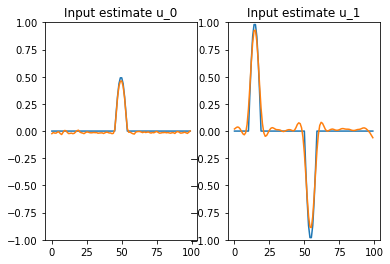

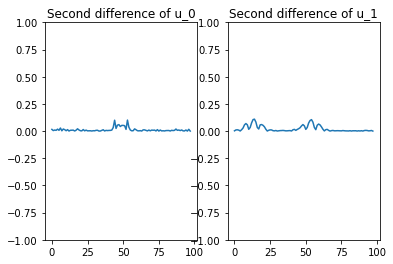

In [539]:
m = B.shape[1]
#second-difference matrix
D2 = second_difference_matrix( N, m )

Uhat_HP, x0hat_HP, fval_HP = tikhonov_optimization_problem(Y_noise, O, G, D2, lam=0.2)

print('Estimate of initial state: ', x0hat_HP.T)

#plot H-P input estimates
fig, axs = plt.subplots(1, 2)
axs[0].plot(U[0::2])
axs[0].plot(Uhat_HP[0::2])
axs[0].set_ylim((-1, 1))
axs[0].set_title("Input estimate u_0")

axs[1].plot(U[1::2])
axs[1].plot(Uhat_HP[1::2])
axs[1].set_ylim((-1, 1))
axs[1].set_title("Input estimate u_1")

#plot second-difference of u
D2U = np.abs(D2@Uhat_HP)

fig, axs = plt.subplots(1, 2)
axs[0].plot(D2U[0::2])
axs[0].set_ylim((-1, 1))
axs[0].set_title("Second difference of u_0")

axs[1].plot(D2U[1::2])
axs[1].set_ylim((-1, 1))
axs[1].set_title("Second difference of u_1") #why this gives a warning?

### 2.1.3. Trend filtering and sparse optimization
If we can assume that a signal is spase,  that is, it is most of the time zero, we can choose replace the $\ell_2$-norm used in the Tikhonov-regularized problem with the $\ell_1$ norm. This problem is often called the **LASSO problem**. The reason why $\ell_1$-norm regularization tends to results in sparse solutions is a whole research topic in itself, see e.g. [E.~Candés et al.](https://link.springer.com/content/pdf/10.1007/s00041-008-9045-x.pdf) and references therein.

The $\ell_1$ regularization results in a convex optimization problem 

$$
\underset{u, x(0)}{\mathrm{min}} || y - \mathcal{O}x(0) - \Gamma u ||^2_2 + \lambda|| Lu ||_1 .
$$

Although there exists no explicit solutions to this type of optimization problems, moderately sized problems can be solved efficiently using numerical convex optimization. A good python package for convex optimization is [CVXPY](https://www.cvxpy.org/).




In [544]:
def l1_optimization_problem(y, O, gamma, L, lam=1):
    '''
    Convex optimization methods using the cvxpy library.
    '''
    u = cp.Variable((gamma.shape[1], 1), complex=False)
    x0 = cp.Variable((O.shape[1], 1), complex=False)
    objective = cp.Minimize(cp.sum_squares(y - O @ x0 - gamma @ u) + lam * cp.pnorm(L @ u, 1))
    prob = cp.Problem(objective)
    prob.solve()

    return u.value, x0.value, prob.value

Below we solve the $\ell_1$-regularized input reconstruction problem.

Estimate of initial state:  [[ 0.5000294   0.09966    -0.09659835]]


Text(0.5, 1.0, 'Second difference of u_1')

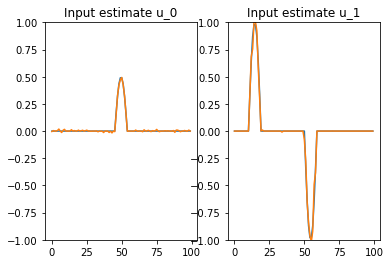

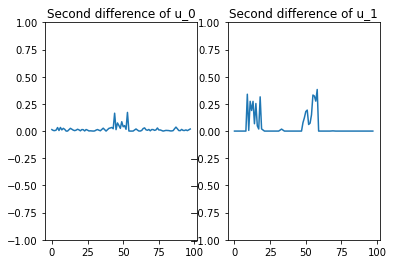

In [551]:
#solve l1 trend filtering problem
Uhat_l1, x0hat_l1, fval_l1 = l1_optimization_problem(Y_noise, O, G, L, lam=0.01)

print('Estimate of initial state: ', x0hat_l1.T)

#plot H-P input estimates
fig, axs = plt.subplots(1, 2)
axs[0].plot(U[0::2])
axs[0].plot(Uhat_l1[0::2])
axs[0].set_ylim((-1, 1))
axs[0].set_title("Input estimate u_0")

axs[1].plot(U[1::2])
axs[1].plot(Uhat_l1[1::2])
axs[1].set_ylim((-1, 1))
axs[1].set_title("Input estimate u_1")

#plot second-difference of u
D2U = np.abs(D2@Uhat_l1)

fig, axs = plt.subplots(1, 2)
axs[0].plot(D2U[0::2])
axs[0].set_ylim((-1, 1))
axs[0].set_title("Second difference of u_0")

axs[1].plot(D2U[1::2])
axs[1].set_ylim((-1, 1))
axs[1].set_title("Second difference of u_1") #why this gives a warning?

We can also enforce other structure in a solution, e.g., sparsity of piece-wise linearity, step-wise changes etc., see [Kim, Seung-Jean, et al, (2009)](https://epubs.siam.org/doi/abs/10.1137/070690274), [Shirdel et al. (2016)](https://www.sciencedirect.com/science/article/pii/S0959152416300531), and [Manngård et al. (2017)](https://www.sciencedirect.com/science/article/pii/B9780444639653500532) by determining $L$ accordingly. An interesting research problem would be on how to determine $L$ to best represent common disturbances acting on propulsion-system drivetrains.

### 2.1.4. Estimation of signals with sparse frequency-domain representations
In sparse optimization a common assumption is that signals have a sparse Fourier-series representation. In that case, $u$ would be expanded in terms of the Fourier-series coefficients

$$
u(n) = \frac{1}{N}\sum_{k=0}^{N-1} U_k \mathrm{e}^{\mathrm{i}2\pi kn/N},
$$
and $u = FU$, where the elements of the matrix $F$ are determined by the basis functions coefficients $F_{n,k} = \mathrm{e}^{\mathrm{i}2\pi kn/N}$. The assumption that $u$ only contains a few frequency components (such as harmonic frequencies), i.e. $U$ is sparse, can be enforced by solving the following $\ell_1$-regularized sparse-optimization problem

$$
\underset{U\in\mathbb{C}^N, x(0)}{\mathrm{min}} || y - \mathcal{O}x(0) - \Gamma FU ||^2_2 + \lambda|| U ||_1.
$$

Note that the unknowns $U_k$ here are complex-valued. Although this increases the complexity of the problem, most convex optimization solvers have no problems handeling complex variables.


# X. Other remarks

## X.1. Non-uniformly sampled LTI systems
M.M. 6.3.2023 - Draft: Not proofread!

In practice, systems are often not sampeled with a constant sampling rate. This is especially true for rotating machinery. It is not uncommon that angular velocities, and twist are measured a fixed number of times per revolution. Thus, as the angular velocity changes, the sampling rate is not constant. However, unlike for a Kalman filter which in it's standard form requires a fixed sampling rate, non-uniform sampling rates can quite easily be incorporated in the proposed convex optimization-based estimation framework.

Consider a contineous-time LTI system sampeled at time instances $t = t_0, t_1,..., t_n$

\begin{align}
\dot{x}(t) &= Ax(t) + Bu(t)\\
y(t_k) &= Cx(t_k).
\end{align}

To solve the differential equaiton first recall that (cf. [wiki.](https://en.wikipedia.org/wiki/Discretization#Derivation))

\begin{equation}
\frac{\mathrm{d}}{\mathrm{d}t}\left( \mathrm{e}^{-At}x(t) \right) = \mathrm{e}^{-At}\left(\dot{x}(t) - Ax(t)\right)
\end{equation}

(by the product rule). Pre-multiplying the state-equation with $\mathrm{e}^{-At}$ and rearranging the terms gives

\begin{equation}
    \mathrm{e}^{-At}\left( \dot{x}(t) - Ax(t) \right) = \mathrm{e}^{-At}Bu(t)
\end{equation}

or  equivalently

\begin{equation}
    \frac{\mathrm{d}}{\mathrm{d}t}\left( \mathrm{e}^{-At}x(t) \right) = \mathrm{e}^{-At}Bu(t).
\end{equation}

Integrating the above expression from $t_k$ to $t_{k+1}$ gives

\begin{equation}
    \mathrm{e}^{-At_{k+1}}x(t_{k+1}) -  \mathrm{e}^{-At_{k}}x(t_{k}) = \int_{t_k}^{t_{k+1}}\mathrm{e}^{-At}Bu(t) \mathrm{d}t
\end{equation}

and multiply by $\mathrm{e}^{At_{k+1}}$ yields

\begin{equation}
    x(t_{k+1}) =  \mathrm{e}^{A(t_{k+1} - t_{k})}x(t_{k}) + \int_{t_k}^{t_{k+1}}\mathrm{e}^{A(t_{k+1} - t)}Bu(t) \mathrm{d}t.
\end{equation}

By assuming that the input is constant inbetween samples (cf. [wiki.](https://en.wikipedia.org/wiki/Discretization#Derivation)), an exact solution to the differential equtions is obtained

\begin{align}
    x(t_{k+1}) &=  \mathrm{e}^{A(t_{k+1} - t_{k})}x(t_{k}) + \int_{t_k}^{t_{k+1}}\mathrm{e}^{A(t_{k+1} - t)}\mathrm{d}t Bu(t_k)\\
               &=  \mathrm{e}^{A(t_{k+1} - t_{k})}x(t_{k}) + \int_{0}^{t_{k+1}-t_k}\mathrm{e}^{A\tau}\mathrm{d}\tau Bu(t_k)\\
               &=  \mathrm{e}^{A(t_{k+1} - t_{k})}x(t_{k}) + A^{-1}\mathrm{e}^{A\tau}\Big|_0^{t_{k+1}-t_k} Bu(t_k)\\
               &=  \mathrm{e}^{A(t_{k+1} - t_{k})}x(t_{k}) + \left( A^{-1}\mathrm{e}^{A(t_{k+1}-t_k)} - A^{-1} \right) Bu(t_k)\\
               &=  \mathrm{e}^{A(t_{k+1} - t_{k})}x(t_{k}) + A^{-1}\left( \mathrm{e}^{A(t_{k+1} - t_k)} - I  \right)Bu(t_k).
\end{align}

The solution is of the form of a time-varying state-space model
\begin{align}
x(t_{k+1}) &= A_{k}x(t_k) + B_{k}u(t_k),\\
y(t_k) &= Cx(t_k)
\end{align}

with system matrices defined as

\begin{align}
A_{k} &= \mathrm{e}^{A(t_{k+1} - t_{k})}x(t_{k}),\\
B_{k} &= A^{-1}( A_k - I  )B,
\end{align}


### X.1.1. Impulse response
Analogous to the derivation in previous section, we have that, given $x(0)$, the state at time-point $t$ is given by

\begin{equation}
    x(t) = \mathrm{e}^{At}x(0) + \int_{0}^t \mathrm{e}^{A\tau}Bu(\tau)\mathrm{d}\tau,
\end{equation}

and the impulse response is obtained by passing the input signal $u(t)=\delta(\tau)$, where $\delta$ is the Dirac's delta function (see e.g. [wiki.](https://en.wikipedia.org/wiki/Dirac_delta_function). For $x(0) = 0$. We have

\begin{align}
x(t) &= \mathrm{e}^{At}x(0) \int_{0}^t \mathrm{e}^{A\tau}B\delta(\tau)\mathrm{d}\tau = \mathrm{e}^{At}B,
\end{align}

and the impulse response is

\begin{equation}
y_\delta(t) = C\mathrm{e}^{At}B.
\end{equation}

Equivalently, from the results in previous section, the impulse response at time instances $t_0, t_1, ..., t_n$ is

\begin{align}
    y_\delta(t_0) &= 0,\\
    y_\delta(t_k) &= C\mathrm{e}^{At_k}B = C\left(\prod_{n=1}^{k-1} A_n\right)B_0, ~k>0
\end{align}

<span style="color:red">Verify this numerically, indices might be wrong! I would expect $B_0 = B$</span>

### X.1.2.The data equation
The data equation is formed analogously to in the previous section and is given by

\begin{equation}
\begin{bmatrix}
y(t_0)\\
y(t_1)\\
y(t_2)\\
y(t_3)\\
\vdots\\
\end{bmatrix} =
\begin{bmatrix}
C\\
CA_0\\
CA_1A_0\\
CA_2A_1A_0\\
\vdots
\end{bmatrix}x(t_0)
+
\begin{bmatrix}
0          &0          &0          &\cdots\\
CB_0       &0          &0          &\cdots\\
CA_1B_0    &CB_1       &0          &\cdots\\
CA_2A_1B_0 &CA_2B_1    &CB_2       &\cdots\\
\vdots     &\vdots     &\vdots     &\ddots
\end{bmatrix}
\begin{bmatrix}
u(t_0)\\
u(t_1)\\
u(t_2)\\
u(t_3)\\
\vdots
\end{bmatrix}.
\end{equation}

Alternatively, the system can be expressed using matrix exponentials by noting that 

$$
A_{n-1} \cdots A_2A_1A_0 = \prod_{k=0}^{n-1} A_k = \mathrm{e}^{A(t_{1}-t_0)}\mathrm{e}^{A(t_{2}-t_1)}\mathrm{e}^{A(t_{3}-t_2)} \cdots \mathrm{e}^{A(t_{n}-t_{n-1})} = \mathrm{e}^{A(t_{n}-t_0)}.
$$

**Note** If the assumption that the input is constant in between samples is to restrictive, some other interpolation model can be applied, e.g. (maybe) the trapetzoidal rule could work.